## U-Net

In [9]:
import torch
from torch import nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from tqdm import tqdm
import math
import torchvision
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F

In [10]:
## ConvBlock
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),  ## padding=1 keep input and output have same height and width
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.convs(x)

In [17]:
## U-Net
class UNet(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        self.down1=ConvBlock(in_ch, 64)
        self.down2=ConvBlock(64, 128)
        self.bot1=ConvBlock(128, 256)  ## deeper squeeze
        self.up2=ConvBlock(128+256, 128)  ## concatenate with down2 in dim1
        self.up1=ConvBlock(128+64, 64)  ## concatenate with down1 in dim1
        self.out=nn.Conv2d(64, in_ch, 1)

        self.maxpool=nn.MaxPool2d(2)  
        self.upsample=nn.Upsample(scale_factor=2, mode="bilinear")  ## twice as before
    
    def forward(self, x):
        x1=self.down1(x)
        x=self.maxpool(x1)
        x2=self.down2(x)
        x=self.maxpool(x2)
        x=self.bot1(x)

        x=self.upsample(x)
        x=torch.cat([x, x2], dim=1)
        x=self.up2(x)
        x=self.upsample(x)
        x=torch.cat([x, x1], dim=1)
        x=self.up1(x)
        x=self.out(x)

        return x

In [18]:
## using random data for demo
model=UNet()
x=torch.randn(10, 1, 28, 28)
y=model(x)
print(y.shape)

torch.Size([10, 1, 28, 28])


## 正弦位置编码

In [19]:
def _pos_encoding(t, output_dim, device='cpu'):
    D = output_dim
    v = torch.zeros(D, device=device)
    i = torch.arange(0, D, device=device)
    div_term = 10000 * (i / D)

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])
    return v

In [20]:
v = _pos_encoding(1, 16) # input is 1, output dim is 16
print(v.shape)

torch.Size([16])


In [21]:
## batch position encoding
def pos_encoding(ts, output_dim, device='cpu'):
    batch_size = len(ts)
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(ts[i], output_dim, device)
    return v

In [22]:
v = pos_encoding(torch.tensor([1,2,3]), 16)
print(v.shape)

torch.Size([3, 16])


In [23]:
## add position information into the ConvBlock
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),  ## padding=1 keep input and output have same height and width
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )

    def forward(self, x, v):
        N, C, _, _ = x.shape
        v = self.mlp(v)
        v = v.view(N, C, 1, 1) # reshape (N,C) into (N,C,1,1)
        y = self.convs(x + v)
        return y

In [24]:
class UNet(nn.Module):
    def __init__(self, in_ch = 1, time_embed_dim = 100):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        self.down1=ConvBlock(in_ch, 64, time_embed_dim)
        self.down2=ConvBlock(64, 128, time_embed_dim)
        self.bot1=ConvBlock(128, 256, time_embed_dim)  ## deeper squeeze
        self.up2=ConvBlock(128+256, 128, time_embed_dim)  ## concatenate with down2 in dim1
        self.up1=ConvBlock(128+64, 64, time_embed_dim)  ## concatenate with down1 in dim1
        self.out=nn.Conv2d(64, in_ch, 1)

        self.maxpool=nn.MaxPool2d(2)  
        self.upsample=nn.Upsample(scale_factor=2, mode="bilinear")  ## twice as before
    
    def forward(self, x, timesteps):
        ## sin position encoding
        v = pos_encoding(timesteps, self.time_embed_dim, x.device)
        x1=self.down1(x, v)
        x=self.maxpool(x1)
        x2=self.down2(x, v)
        x=self.maxpool(x2)
        x=self.bot1(x, v)

        x=self.upsample(x)
        x=torch.cat([x, x2], dim=1)
        x=self.up2(x, v)
        x=self.upsample(x)
        x=torch.cat([x, x1], dim=1)
        x=self.up1(x, v)
        x=self.out(x)
    
        return x

## 扩散过程
基于q(xt|xt-1)采样

In [25]:
x = torch.randn(3, 64, 64)
T = 1000
betas = torch.linspace(0.0001, 0.02, T)

for t in range(T):
    beta = betas[t]
    eps = torch.rand_like(x)
    res = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

(276, 183, 3)


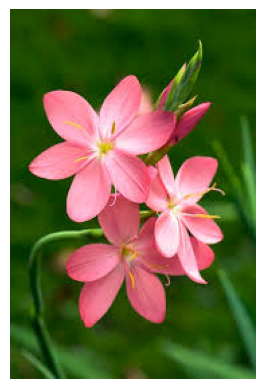

torch.Size([3, 276, 183])


In [26]:
## diffusion process of image
# load img
file_path = "./flower.png"
image = Image.open(file_path).convert("RGB")
image_array = np.array(image)
print(image_array.shape)

plt.imshow(image_array)
plt.axis('off')
plt.show()

## transform
transform = transforms.ToTensor()
x = transform(image)
print(x.shape)

In [27]:
## reverse
def reverse_to_img(x):
    x = x * 255
    x = x.clamp(0, 255)
    x = x.to(torch.uint8)
    to_pil = transforms.ToPILImage()
    return to_pil(x)

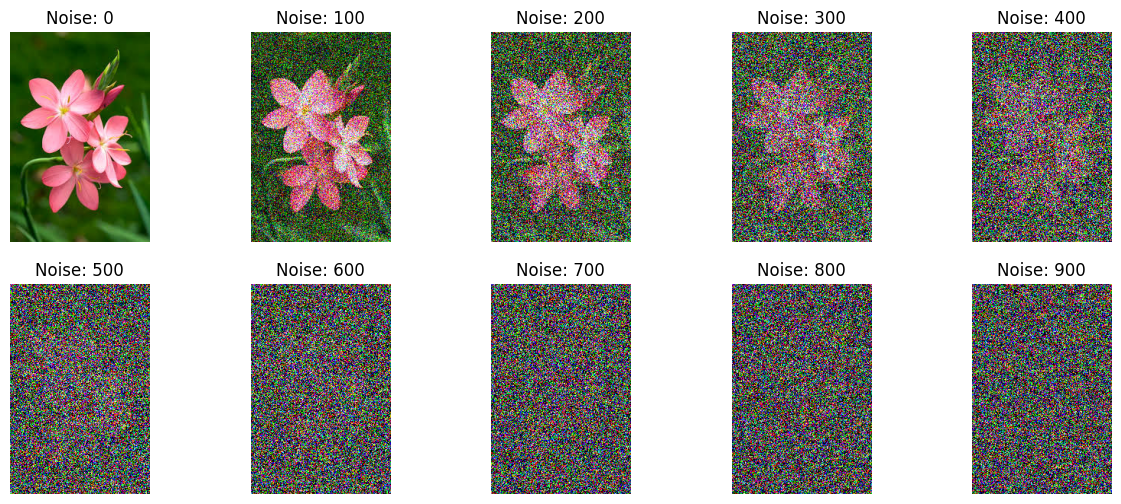

In [28]:
## diffusion process
T = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)
imgs = []

for t in range(T):
    if t % 100 == 0:
        img = reverse_to_img(x)
        imgs.append(img)
    
    beta = betas[t]
    eps = torch.randn_like(x)
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

plt.figure(figsize=(15, 6))
for i, img in enumerate(imgs[:10]):
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f'Noise: {i * 100}')
    plt.axis('off')

plt.show()

基于q(xt | x0)采样

In [29]:
x = torch.tensor([1, 2, 3, 4]) # cumulative product
print(torch.cumprod(x, dim=0))

tensor([ 1,  2,  6, 24])


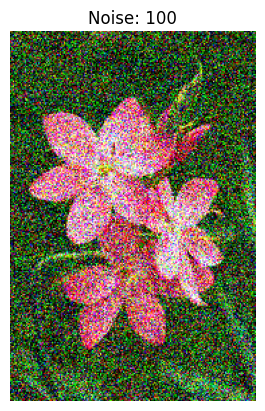

In [30]:
## diffusion process of image
# load img
file_path = "./flower.png"
image = Image.open(file_path).convert("RGB")

## transform
transform = transforms.ToTensor()
x = transform(image)

T = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)

def add_noise(x_0, t, betas):
    T = len(betas)
    assert t >= 1 and t <= T

    alphas = 1 - betas
    alphas_bar = torch.cumprod(alphas, dim=0)
    t_idx = t - 1
    alpha_bar = alphas_bar[t_idx]

    eps = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * eps
    return x_t

## 生成时刻100的图像
t = 100
x_t = add_noise(x, t, betas)

img = reverse_to_img(x_t)
plt.imshow(img)
plt.title(f'Noise: {t}')
plt.axis('off')
plt.show()

In [31]:
## class 'Diffuser'
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
    
    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= self.num_timesteps).all()
        t_idx = t - 1

        alpha_bar = self.alpha_bars[t_idx]
        N = alpha_bar.size(0)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        
        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise

        return x_t, noise

## 数据生成
一步去噪处理

In [32]:
## class 'Diffuser' with denoise
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
    
    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= self.num_timesteps).all()
        t_idx = t - 1

        alpha_bar = self.alpha_bars[t_idx]
        N = alpha_bar.size(0)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        
        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    
    def denoise(self, model, x, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t-1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx - 1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval() ## inference
        with torch.no_grad():
            eps = model(x, t)
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0

        mu = (x - ((1-alpha) / torch.sqrt(1 - alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1 - alpha) * (1 - alpha_bar_prev) / (1 - alpha_bar))
        return mu + noise * std
    

In [33]:
## data generation
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
    
    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= self.num_timesteps).all()
        t_idx = t - 1

        alpha_bar = self.alpha_bars[t_idx]
        N = alpha_bar.size(0)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        
        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    
    def denoise(self, model, x, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t-1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx - 1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval() ## inference
        with torch.no_grad():
            eps = model(x, t)
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0

        mu = (x - ((1-alpha) / torch.sqrt(1 - alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1 - alpha) * (1 - alpha_bar_prev) / (1 - alpha_bar))
        return mu + noise * std
    
    
    def reverse_to_img(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)
    

    def sample(self, model, x_shape = (20, 1, 28, 28)):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t)
        
        images = [self.reverse_to_img(x[i]) for i in range(batch_size)]
        return images

## train
训练模型

In [37]:
img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 10
lr = 1e-3
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

def show_images(images, rows=2, cols=10):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, i+1)
            plt.imshow(images[i], cmap = 'gray')
            plt.axis('off')
            i += 1
    
    plt.show()

In [38]:
## preparation
preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root = '../mnist', download=False, transform=preprocess) # pay attention to datasets
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

diffuser = Diffuser(num_timesteps, device=device)
model = UNet(in_ch=1, time_embed_dim=100)
model.to(device)
optimizer = Adam(model.parameters(), lr = lr)

100%|██████████| 469/469 [01:27<00:00,  5.35it/s]


Epoch 0 | Loss: 0.04980500799808294


100%|██████████| 469/469 [01:27<00:00,  5.34it/s]


Epoch 1 | Loss: 0.029886182766955798


100%|██████████| 469/469 [01:39<00:00,  4.71it/s]


Epoch 2 | Loss: 0.02664388531147798


100%|██████████| 469/469 [01:40<00:00,  4.66it/s]


Epoch 3 | Loss: 0.024067277601088035


100%|██████████| 469/469 [01:52<00:00,  4.15it/s]


Epoch 4 | Loss: 0.022759506272386387


100%|██████████| 469/469 [01:50<00:00,  4.26it/s]


Epoch 5 | Loss: 0.02213028133876606


100%|██████████| 469/469 [01:43<00:00,  4.53it/s]


Epoch 6 | Loss: 0.021308341700988793


100%|██████████| 469/469 [01:41<00:00,  4.64it/s]


Epoch 7 | Loss: 0.020813737815218187


100%|██████████| 469/469 [01:41<00:00,  4.62it/s]


Epoch 8 | Loss: 0.020565067038639015


100%|██████████| 469/469 [01:42<00:00,  4.58it/s]


Epoch 9 | Loss: 0.020011811513207488


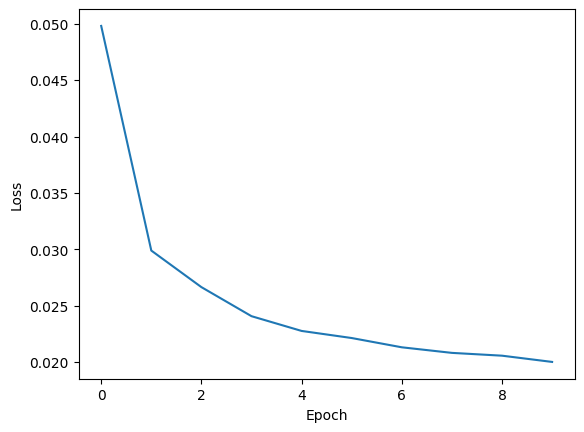

100%|██████████| 1000/1000 [00:21<00:00, 47.55it/s]


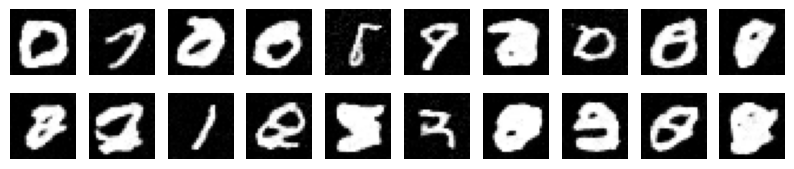

In [39]:
losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        t = torch.randint(1, num_timesteps+1, (len(x), ), device=device)

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise, noise_pred)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1
    
    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f'Epoch {epoch} | Loss: {loss_avg}')

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

images = diffuser.sample(model)
show_images(images)
